<a href="https://colab.research.google.com/github/RodriCalle/cc41_tf_201915889_201910127_201917028_201718169_20141a449/blob/master/Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import graphviz as gv
import math
import heapq as hq
from google.colab import files

In [19]:
def adjlShow(L, labels=None, directed=False, weighted=False, path=[], layout="sfdp"):
  g = gv.Digraph("G") if directed else gv.Graph("G")
  g.graph_attr["layout"] = layout
  g.edge_attr["color"] = "gray"
  g.node_attr["color"] = "orangered"
  g.node_attr["width"] = "0.1"
  g.node_attr["height"] = "0.1"
  g.node_attr["fontsize"] = "8"
  g.node_attr["fontcolor"] = "mediumslateblue"
  g.node_attr["fontname"] = "monospace"
  n = len(L)
  for u in range(n):
    g.node(str(u), labels[u] if labels else str(u))
  added = set()
  for v, u in enumerate(path):
    if u != None:
      g.edge(str(u), str(v), dir="forward", penwidth="2", color="orange")
      added.add(f"{u},{v}")
      added.add(f"{v},{u}")
  if weighted:
    for u in range(n):
      for v, w in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v), str(w))
        elif directed:
          g.edge(str(u), str(v), str(w))
  else:
    for u in range(n):
      for v in L[u]:
        if not directed and not f"{u},{v}" in added:
          added.add(f"{u},{v}")
          added.add(f"{v},{u}")
          g.edge(str(u), str(v))
        elif directed:
          g.edge(str(u), str(v))
  return g

#Generador de datasets

Algoritmo mediante el cual se generan de manera aleatoria los arreglos de los puntos de almacen y los puntos de entrega.
1. Primero se genera la cantidad de almacenes entre 50 y 100, y la cantidad de entregas entre 2500 y 5000.
2. Luego creamos los arreglos de almacenes y entregas vacíos.
3. Posteriormente se genera dos arreglos "x" e "y" para almacen y otros dos para entrega, el rango de valor que puede tomar el "x" o "y" esta entre 1 y 1000
4. Para finalizar se recorre los arreglos principales (almacenes y entregas) y se añaden los pares ordenados.


In [20]:
qAlm = random.randint(50,100)
qEnt = random.randint(2500,5000)

almacenes, entregas = [], []

almacenx = np.random.randint(1,1000, size=qAlm)
almaceny = np.random.randint(1,1000, size=qAlm)

entregax = np.random.randint(1,1000, size=qEnt)
entregay = np.random.randint(1,1000, size=qEnt)

for i in range(qAlm):
  almacenes.append( [almacenx[i], almaceny[i]] )
for i in range(qEnt):
  entregas.append( [entregax[i], entregay[i]] )

#print("Cantidad de almacenes: ", qAlm)
#print(almacenes)
#print("Cantidad de puntos de entrega: ", qEnt)
#print(entregas)

Una vez generado los arreglos con los pares ordenados para cada punto, se escriben en arcchivos. El arreglo almacenes se escribe en el archivo "puntos_almacenes.csv" y el arreglo entregas en "puntos_entregas.csv"

In [21]:
almacenesFile = open('puntos_almacenes.csv', 'w')
with almacenesFile:
  writer = csv.writer(almacenesFile)
  writer.writerows(almacenes)

entregasFile = open('puntos_entrega.csv', 'w')
with entregasFile:
  writer = csv.writer(entregasFile)
  writer.writerows(entregas)

#with open('almacenes.csv', newline="") as almacenesFile:
#  reader = csv.reader(almacenesFile, delimiter=",")
#  for row in reader:
#    print(row)

#Figure

Gráfico de los puntos de distribución (azul) y de los puntos de entrega (rojo), con escala de 0 a 1000.

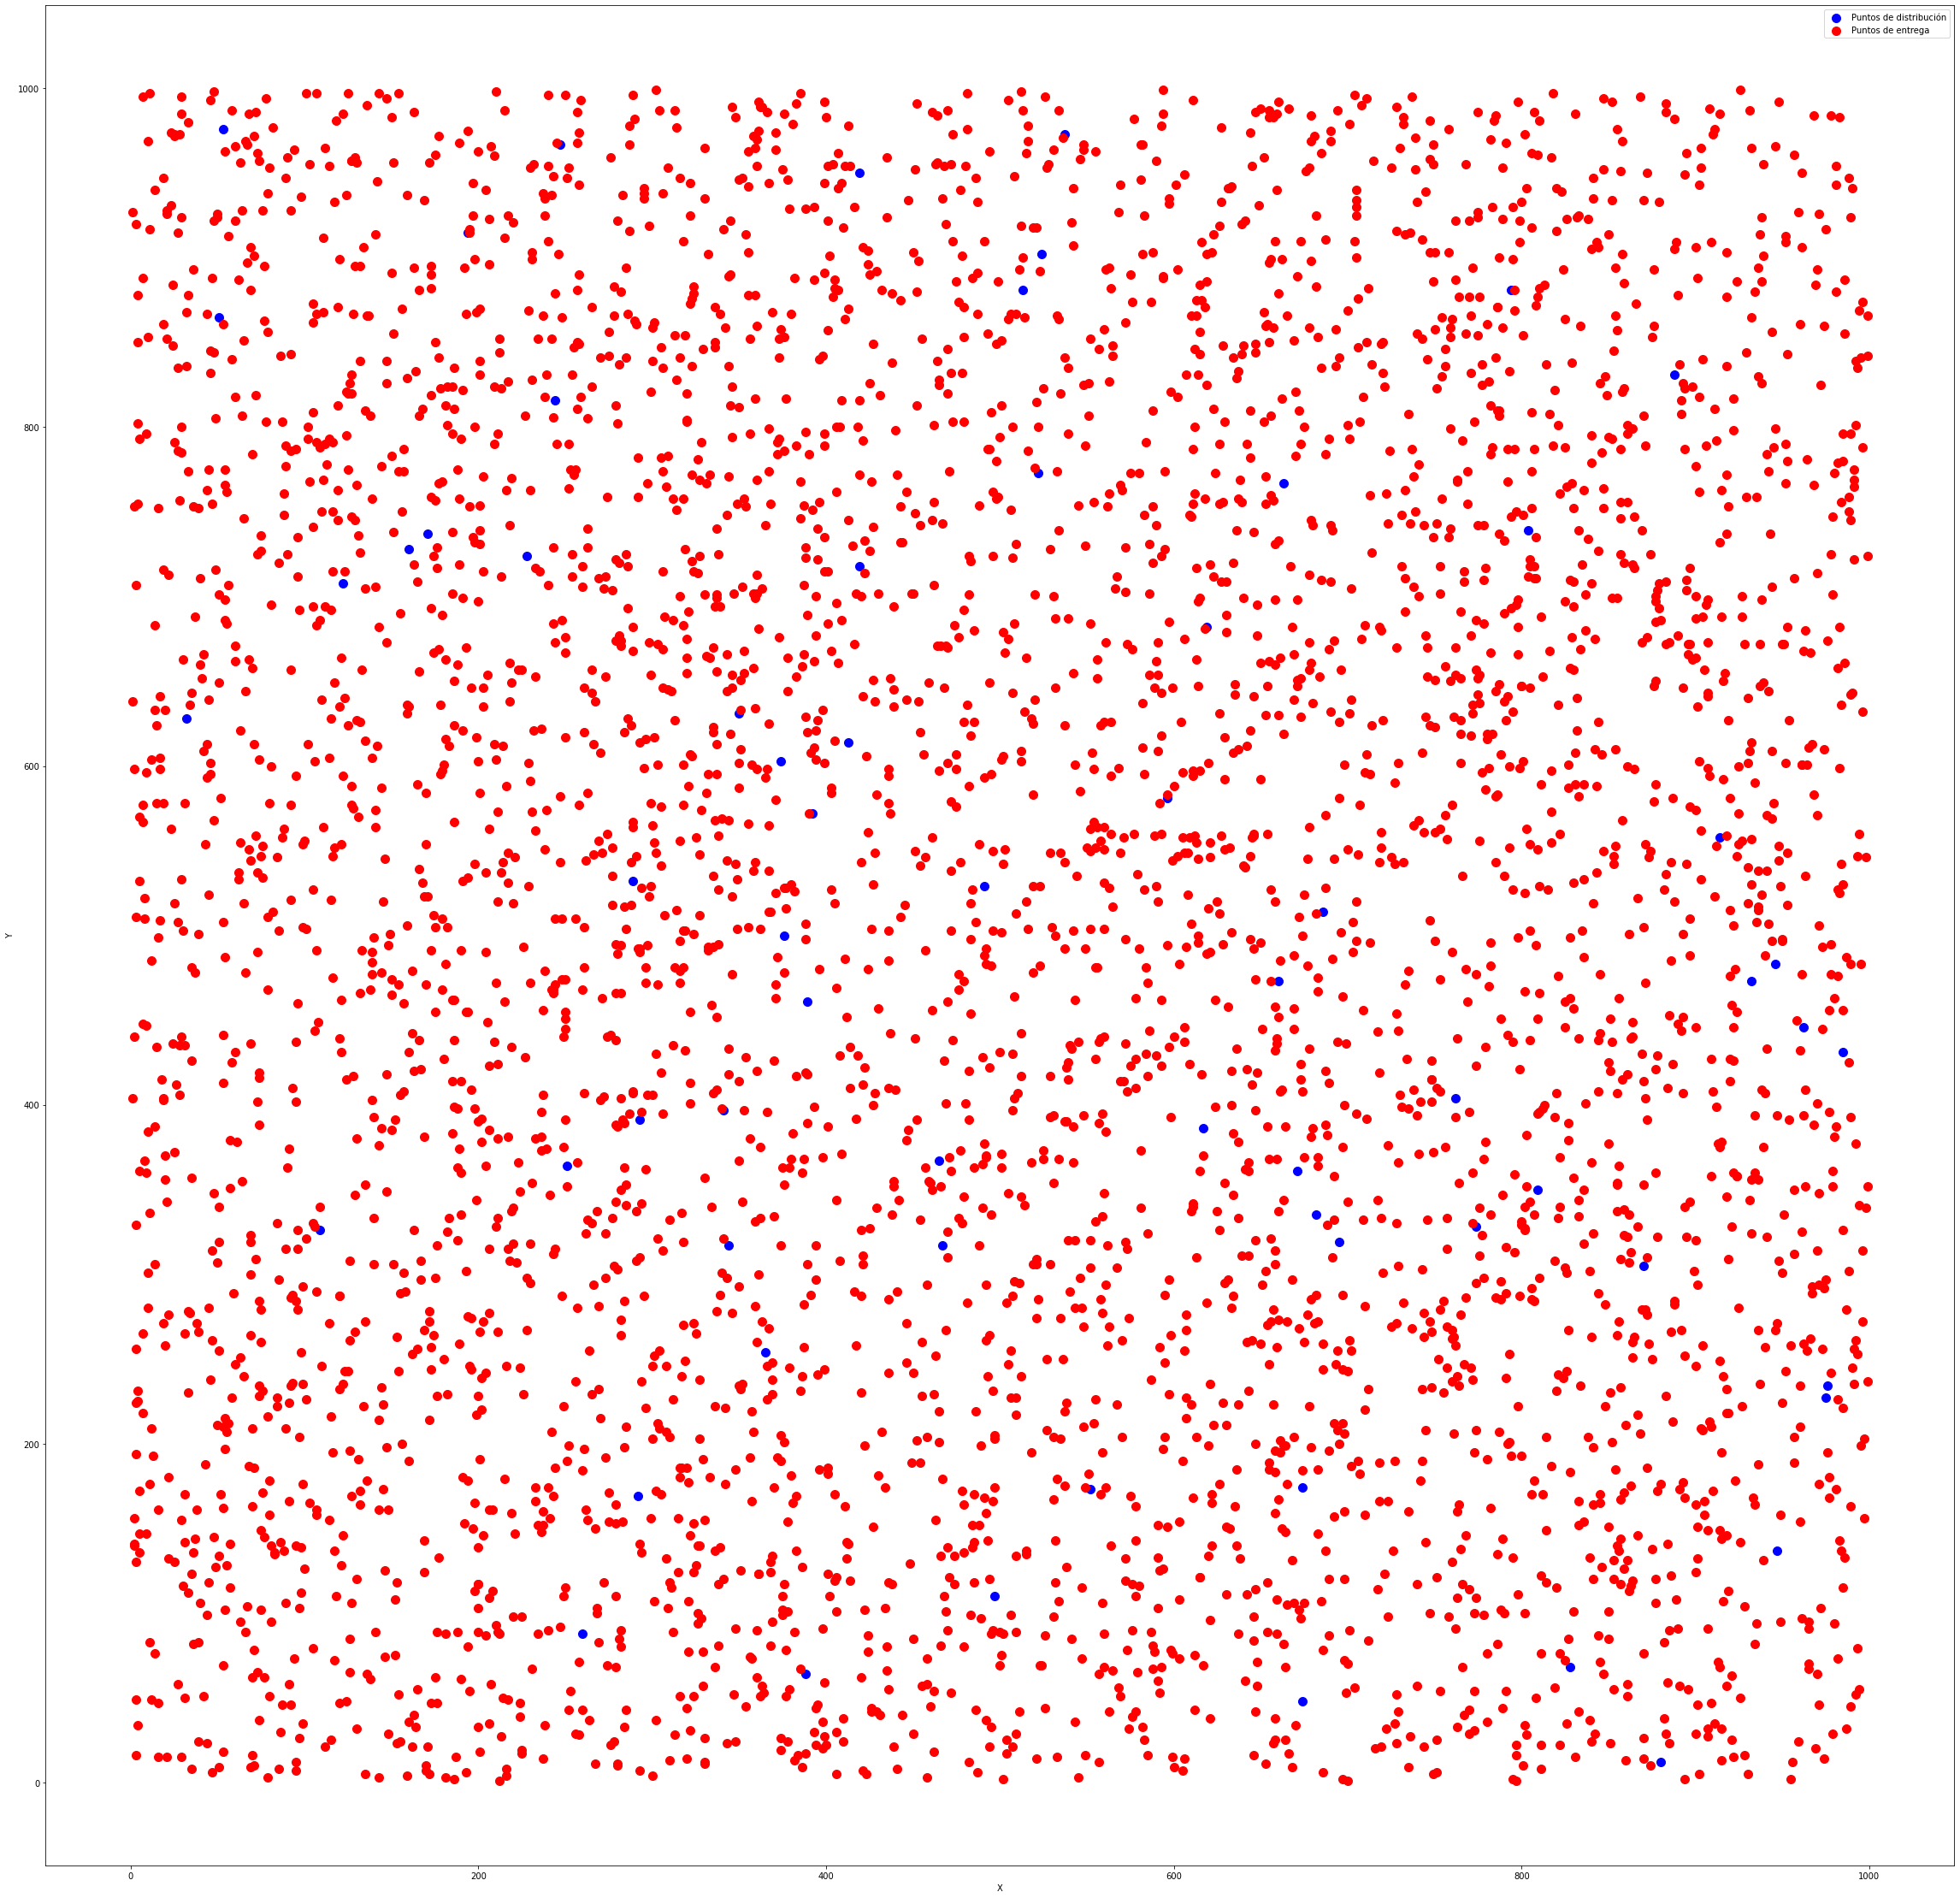

In [22]:
plt.figure(num=1, figsize=(40,40))
plt.scatter(almacenx,almaceny,s=100,color="blue", label="Puntos de distribución")
plt.scatter(entregax,entregay,s=100,color="red", label="Puntos de entrega")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

#Grafos

Una vez analizado el planteamiento del problema y nuestro espacio de busqueda, consideramos que se necesita un grafo de 1 000 * 1 000, lo cual resulta en un grafo de 1 000 000 de nodos, y sus vertices son hacia sus vecinos.

1. Primero establecemos una lista de adyacencia vacia es decir con todos los nodos y con las aristas de cada nodo.
2. Luego con la función setKnownPoints y los arreglos de almacen y entrega se crea un arreglo de etiquetas que permiten diferenciar los nodos del grafo.
3. Por último con la función getGrapphWeighted, obtendremos el grafo con los pesos de cada arista.

Funciones usadas:
- Convertir punto (x,y) a posición de nodo
```
pos = x * size + y
```
- Convertir posición de nodo a punto (x,y)
```
x = pos // size
y = pos % size
```


A continuación se ha generado un ejemplo de prueba con pocos datos para validar los algoritmos desarrollados.

In [23]:
def setEmptyGraph(size):
  n = size*size
  G = [ [] for _ in range(n) ]
  for x in range(size):
    for y in range(size):
      if(size > x + 1):
        G[ ((x * size) + y) ].append(((x+1) * size) + y)
      if(0 <= x - 1):
        G[ ((x * size) + y) ].append(((x-1) * size) + y)
      if(size > y + 1):
        G[ ((x * size) + y) ].append((x * size) + (y+1))
      if(0 <= y - 1):
        G[ ((x * size) + y) ].append((x * size) + (y-1))
  return G

def setKnownPoints(size, almacen, entrega):
  id = ["empty"]*(size*size)
  for a in almacen:
    x, y = a[0], a[1]
    pos = x*size + y
    id[pos] = "A"
  for a in entrega:
    x, y = a[0], a[1]
    pos = x*size + y
    id[pos] = "E"
  return id

def getGraphWeighted(G):
  adjlListWeighted = [[] for i in range(len(G))]
  for i in range(len(G)):
    for j in range(len(G[i])):
      adjlListWeighted[i].append(   ( G[i][j], round( math.sqrt( (( (i // (len(G)/2) ) - (G[i][j] //  (len(G)/2) ) )**2) + (( (i %  (len(G)/2) ) - (G[i][j] %  (len(G)/2) ) )**2)   )          )  )    )
  return adjlListWeighted

#Algoritmo de Dijkstra

In [24]:
def dijkstra(G, s):
  n = len(G)
  visited = [False]*n
  path = [None]*n
  cost = [math.inf]*n
  cost[s] = 0
  queue = [(0, s)]
  while queue:
    g_u, u = hq.heappop(queue)
    if not visited[u]:
      visited[u] = True
      for v, w in G[u]:
        f = g_u + w
        if f < cost[v]:
          cost[v] = f
          path[v] = u
          hq.heappush(queue, (f, v))

  return path, cost

## Ejemplo de prueba

[[4, 1], [5, 2, 0], [6, 3, 1], [7, 2], [8, 0, 5], [9, 1, 6, 4], [10, 2, 7, 5], [11, 3, 6], [12, 4, 9], [13, 5, 10, 8], [14, 6, 11, 9], [15, 7, 10], [8, 13], [9, 14, 12], [10, 15, 13], [11, 14]]
['A', 'A', 'empty', 'empty', 'E', 'E', 'A', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty', 'empty']
[[(4, 4), (1, 1)], [(5, 4), (2, 1), (0, 1)], [(6, 4), (3, 1), (1, 1)], [(7, 4), (2, 1)], [(8, 4), (0, 4), (5, 1)], [(9, 4), (1, 4), (6, 1), (4, 1)], [(10, 4), (2, 4), (7, 1), (5, 1)], [(11, 4), (3, 4), (6, 1)], [(12, 4), (4, 4), (9, 1)], [(13, 4), (5, 4), (10, 1), (8, 1)], [(14, 4), (6, 4), (11, 1), (9, 1)], [(15, 4), (7, 4), (10, 1)], [(8, 4), (13, 1)], [(9, 4), (14, 1), (12, 1)], [(10, 4), (15, 1), (13, 1)], [(11, 4), (14, 1)]]


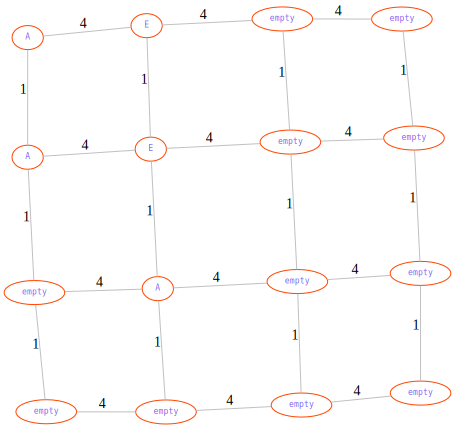

In [25]:
alm = [[0,1],[1,2],[0,0]]
ent = [[1,0],[1,1]]

size = 4

Gp = setEmptyGraph(size)
print(Gp)

labels = setKnownPoints(size, alm, ent)
print(labels)

GWp = getGraphWeighted(Gp)
print(GWp)

adjlShow(GWp, labels=labels, weighted=True)

Ahora se guarda la lista de adyacencia en un archivo "adjlistexample.txt"

In [26]:
graphFile = open('adjlistexample.txt', 'w')
with graphFile:
  writer = csv.writer(graphFile)
  writer.writerows(Gp)

[None, 0, 1, 2, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
None -> 0
0 -> 1
1 -> 2
2 -> 3
0 -> 4
1 -> 5
2 -> 6
3 -> 7
4 -> 8
5 -> 9
6 -> 10
7 -> 11
8 -> 12
9 -> 13
10 -> 14
11 -> 15


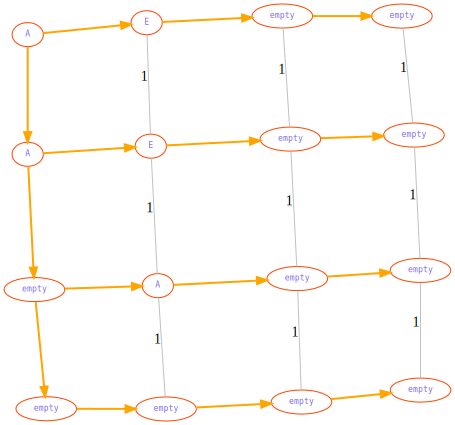

In [27]:
path, cost = dijkstra(GWp, 0)

print(path)
print(cost)

for i in range(len(path)):
  print(path[i], "->", i)

adjlShow(GWp, path=path, labels = labels ,weighted=True)

## Para el proyecto

In [28]:
size = 1000

G = setEmptyGraph(size)
labels = setKnownPoints(size, almacenes, entregas)
GW = getGraphWeighted(G)

#adjlShow(GW, path=path, weighted=True)

graphFile = open('graph.txt', 'w')
with graphFile:
  writer = csv.writer(graphFile)
  writer.writerows(G)

#files.download('graph.txt')

In [29]:
path, cost = dijkstra(GW, 0)

pathFile = open('dijkstra.txt', 'w')
with pathFile:
  writer = csv.writer(pathFile)
  writer.writerows(str(path))

#files.download('dijkstra.txt')

#Algoritmo de Dijkstra de cada almacen a los puntos de entrega

In [30]:
def getAlmPoint(size, almacen):
  alm = []
  for a in almacen:
    x, y = a[0], a[1]
    pos = x*size + y
    alm.append(pos)
  return alm

def getCoord(pos, size):
  x = pos // size
  y = pos % size
  return [x, y]

def getEntPoint(size, entrega):
  ent = []
  for a in entrega:
    x, y = a[0], a[1]
    pos = x*size + y
    ent.append(pos)
  return ent

def dijkstraEntregas(almacenes, entregas, G):
  sol = [] 
  for i in almacenes:
    path, cost = dijkstra(G,i)
    for j in entregas:
      node = j
      p = [j]
      c = cost[j]
      while node != i:
        node = path[node]
        p.append(node)
      p.reverse()
      sol.append((i,j,c,p))
  return sol

## Ejemplo de prueba

In [31]:
size = 4

arregloAlmP = getAlmPoint(size,alm)
print(arregloAlmP)

arregloEntP = getEntPoint(size,ent)
print(arregloEntP)

djpdP = dijkstraEntregas(arregloAlmP, arregloEntP,GWp)
print(djpdP)

[1, 6, 0]
[4, 5]
[(1, 4, 5, [1, 0, 4]), (1, 5, 4, [1, 5]), (6, 4, 2, [6, 5, 4]), (6, 5, 1, [6, 5]), (0, 4, 4, [0, 4]), (0, 5, 5, [0, 1, 5])]


## Para el proyecto

In [32]:
size = 1000
arregloAlm = getAlmPoint(size,almacenes)
arregloEnt = getEntPoint(size,entregas)

djpd = dijkstraEntregas(arregloAlm, arregloEnt,GW)

djpdFile = open('dijkstraforeach.txt', 'w')
with djpdFile:
  writer = csv.writer(djpdFile)
  writer.writerows(str(djpd))

# Algoritmo para repartir puntos de entrega entre almacenes, utilizar criterio de cercanía.

In [33]:
groupsAlm = [[] for _ in range(4)]
groupsEnt = [[] for _ in range(4)]
size = 4

#ALMACEN
#getCoord(djpd[i][0],size)[0]   x
# getCoord(djpd[i][0],size)[1]   y

#ENTREGA
#getCoord(djpd[i][1],size)[0]  x
#getCoord(djpd[i][1],size)[1]  Y

# print(getCoord(djpd[i][0],size), "->", getCoord(djpd[i][1],size))

#for i in range(len(djpd)):
 # if ( getCoord(djpd[i][0],size)[0] >= 0 and getCoord(djpd[i][0],size)[0] <= size/2 and getCoord(djpd[i][0],size)[1] >= 0 and getCoord(djpd[i][0],size)[1] <= size/2 ):
  #  groups[0].append( djpd[i] )
  #if ( getCoord(djpd[i][0],size)[0] >= size/2 and getCoord(djpd[i][0],size)[0] <= size and getCoord(djpd[i][0],size)[1] >= 0 and getCoord(djpd[i][0],size)[1] <= size/2 ):
  #  groups[1].append( djpd[i] )
  #if ( getCoord(djpd[i][0],size)[0] >= 0 and getCoord(djpd[i][0],size)[0] <= size/2 and getCoord(djpd[i][0],size)[1] >= size/2 and getCoord(djpd[i][0],size)[1] <= size ):
   # groups[2].append( djpd[i] )
  #if ( getCoord(djpd[i][0],size)[0] >= size/2 and getCoord(djpd[i][0],size)[0] <= size and getCoord(djpd[i][0],size)[1] >= size/2 and getCoord(djpd[i][0],size)[1] <= size ):
   # groups[3].append( djpd[i] )

for i in range(len(alm)):
  if ( alm[i][0]  >= 0 and alm[i][0] <= (size/2)-1 and alm[i][1] >= 0 and alm[i][1] <= (size/2)-1 ):
    groupsAlm[0].append( alm[i] )
  if ( alm[i][0] >= 0 and alm[i][0] <= (size/2)-1 and alm[i][1] >= size/2 and alm[i][1] <= size-1 ):
    groupsAlm[1].append( alm[i] )
  if ( alm[i][0] >= size/2 and alm[i][0] <= size-1 and alm[i][1] >= 0 and alm[i][1] <= (size/2)-1 ):
    groupsAlm[2].append( alm[i] )
  if ( alm[i][0] >= size/2 and  alm[i][0] <= size-1 and alm[i][1] >= size/2 and alm[i][1] <= size-1 ):
    groupsAlm[3].append( alm[i] )

for i in range(len(ent)):
  if ( ent[i][0]  >= 0 and ent[i][0] <= (size/2)-1 and ent[i][1] >= 0 and ent[i][1] <= (size/2)-1 ):
    groupsEnt[0].append( ent[i] )
  if ( ent[i][0] >= 0 and ent[i][0] <= (size/2)-1 and ent[i][1] >= size/2 and ent[i][1] <= size-1 ):
    groupsEnt[1].append( ent[i] )
  if ( ent[i][0] >= size/2 and ent[i][0] <= size-1 and ent[i][1] >= 0 and ent[i][1] <= (size/2)-1 ):
    groupsEnt[2].append( ent[i] )
  if ( ent[i][0] >= size/2 and  ent[i][0] <= size-1 and ent[i][1] >= size/2 and ent[i][1] <= size-1 ):
    groupsEnt[3].append( ent[i] )

print(groupsAlm)
print(groupsEnt)

[[[0, 1], [0, 0]], [[1, 2]], [], []]
[[[1, 0], [1, 1]], [], [], []]


## Ejemplo de prueba

In [36]:
aP = []*len(alm)

# for i in range(len(djpd)):
#   print(djpd[i][0], "->", djpd[i][1], "Costo: ", djpd[i][2])

w = djpdP[0][2]
for j in range(len(arregloEntP)):
  for i in range(len(djpdP)):
    if ( arregloEntP[j] == djpdP[i][1] and w > djpdP[i][2]):
      w = djpdP[i][2]
      aP.append( djpdP[i] )

print(aP)

[(6, 4, 2, [6, 5, 4]), (6, 5, 1, [6, 5])]


## Proyecto

In [37]:
a = []*len(almacenes)

# for i in range(len(djpd)):
#   print(djpd[i][0], "->", djpd[i][1], "Costo: ", djpd[i][2])

w = djpd[0][2]
for j in range(len(arregloEnt)):
  for i in range(len(djpd)):
    if ( arregloEnt[j] == djpd[i][1] and w > djpd[i][2]):
      w = djpd[i][2]
      a.append( djpd[i] )

print(a)

[(617386, 591654, 26268, [617386, 617387, 617388, 617389, 617390, 617391, 617392, 617393, 617394, 617395, 617396, 617397, 617398, 617399, 617400, 617401, 617402, 617403, 617404, 617405, 617406, 617407, 617408, 617409, 617410, 617411, 617412, 617413, 617414, 617415, 617416, 617417, 617418, 617419, 617420, 617421, 617422, 617423, 617424, 617425, 617426, 617427, 617428, 617429, 617430, 617431, 617432, 617433, 617434, 617435, 617436, 617437, 617438, 617439, 617440, 617441, 617442, 617443, 617444, 617445, 617446, 617447, 617448, 617449, 617450, 617451, 617452, 617453, 617454, 617455, 617456, 617457, 617458, 617459, 617460, 617461, 617462, 617463, 617464, 617465, 617466, 617467, 617468, 617469, 617470, 617471, 617472, 617473, 617474, 617475, 617476, 617477, 617478, 617479, 617480, 617481, 617482, 617483, 617484, 617485, 617486, 617487, 617488, 617489, 617490, 617491, 617492, 617493, 617494, 617495, 617496, 617497, 617498, 617499, 617500, 617501, 617502, 617503, 617504, 617505, 617506, 617507

# Modificar algoritmo Dijkstra para cada almacen, ahora a sus puntos cercanos.